In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 15
END_YEAR = 2015


### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

### Read Gender details

In [50]:
# read gender details - the column names are name, gender - change it to author, gender
#gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender = pd.read_csv('./data-new/name_gender_2017_asiansAsNone.txt')
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())
#TODO: also show proportion! What is the percentage of men and women?

print(gender['author'].nunique())

          author gender
0   gareth beale      m
1    graeme earl      m
2  altaf hossain      m
3   faisal zaman      m
4      m. nasser   none
['m' 'none' 'f']
gender
f       1046534
m       4621274
none    3803920
dtype: int64
1704919


### Read authors with start and end year details

In [51]:
# Different files exists depending upon their career length

#authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorStartEndCareerData = pd.read_csv('./data-new/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print(authorStartEndCareerData.head())

#print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  - ", authorStartEndCareerData['author'].nunique())
#print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])

authorStartEndCareerData before filtering -  112791
authorStartEndCareerData after filtering -  112791
               author  start_year  end_year  total_num_pub  career_length
0          a min tjoa        1979      2017            191             38
1          a-xing zhu        1998      2017             22             19
2  a. a. (louis) beex        1980      2016             31             36
3    a. a. abouelsoud        1996      2016             10             20
4          a. a. ball        1988      2006              5             18
author unique names  -  112791


### Merge credible authors and their gender information

In [52]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
print(authorStartEndCareerData.head())

print("authorStartEndCareerData with duplicates: %s", authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData['author'].nunique())

#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()


       author  start_year  end_year  total_num_pub  career_length gender
0  a min tjoa        1979      2017            191             38   none
1  a min tjoa        1979      2017            191             38   none
2  a min tjoa        1979      2017            191             38   none
3  a min tjoa        1979      2017            191             38   none
4  a min tjoa        1979      2017            191             38   none
authorStartEndCareerData with duplicates: %s 3884297
authorStartEndCareerData no duplicates: %s 112791


### Read Publication data

In [53]:
#authorPublicationData = pd.read_csv('./data/author_publications_1970_2016_asiansAsNone.txt')
authorPublicationData = pd.read_csv('./data-new/author_publications_2017_asiansAsNone.txt')

print('authorPublicationData before filtering - ',authorPublicationData.shape[0])
authorPublicationData = authorPublicationData[authorPublicationData["year"] >= 1970]
print('authorPublicationData after filtering - ',authorPublicationData.shape[0])

authorPublicationData = authorPublicationData.groupby(['year','author']).count().reset_index()
authorPublicationData.rename(columns={'pub_id':'num_pub'}, inplace=True)
print(authorPublicationData.head())

print(authorStartEndCareerData.head())
##remove wrong data
#authorPublicationData = authorPublicationData[authorPublicationData["year"] > 1900]
#print(authorPublicationData[authorPublicationData.author=="a min tjoa"])

print(np.unique(authorStartEndCareerData["start_year"]))


authorPublicationData before filtering -  9471668
authorPublicationData after filtering -  9462275
   year          author  num_pub
0  1970     a. a. afifi        1
1  1970      a. armenti        1
2  1970  a. c. mckellar        1
3  1970  a. c. williams        1
4  1970    a. colin day        1
                 author  start_year  end_year  total_num_pub  career_length  \
0            a min tjoa        1979      2017            191             38   
191          a-xing zhu        1998      2017             22             19   
213  a. a. (louis) beex        1980      2016             31             36   
244    a. a. abouelsoud        1996      2016             10             20   
254          a. a. ball        1988      2006              5             18   

    gender  
0     none  
191   none  
213      m  
244      m  
254      m  
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 199

### Merge Publications with credible authors and their gender information

In [54]:
#authorPublicationData = pd.merge(authorPublicationData, authorStartEndCareerData,  
#                                          how="left", left_on="author", right_on="author")

authorPublicationData = pd.merge(authorPublicationData, authorStartEndCareerData, how="left", on=["author"])


print("authorPublicationData before filtering: %s", authorPublicationData.shape[0])
authorPublicationData = authorPublicationData.dropna(how='any')
print("authorPublicationData after filtering: %s", authorPublicationData.shape[0])

print("authorPublicationData with duplicates: %s", authorPublicationData.shape[0])
authorPublicationData = authorPublicationData.drop_duplicates()
print("authorPublicationData no duplicates: %s", authorPublicationData.shape[0])

#print(authorPublicationData.head(n=2))
print(authorPublicationData['author'].nunique())
#print(authorPublicationData.shape[0])

print(authorPublicationData.head())
#print(authorPublicationData[authorPublicationData.author=="a min tjoa"])


authorPublicationData before filtering: %s 4855468
authorPublicationData after filtering: %s 1317920
authorPublicationData with duplicates: %s 1317920
authorPublicationData no duplicates: %s 1317920
112791
    year            author  num_pub  start_year  end_year  total_num_pub  \
10  1970          a. moore        1      1970.0    2012.0            2.0   
12  1970           a. trew        1      1970.0    2008.0            2.0   
19  1970  adeline paiement        1      1970.0    2017.0           11.0   
21  1970  alain colmerauer        1      1970.0    2008.0            8.0   
23  1970      alan c. shaw        2      1970.0    2000.0           15.0   

    career_length gender  
10           42.0      m  
12           38.0      m  
19           47.0      f  
21           38.0      m  
23           30.0   none  


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


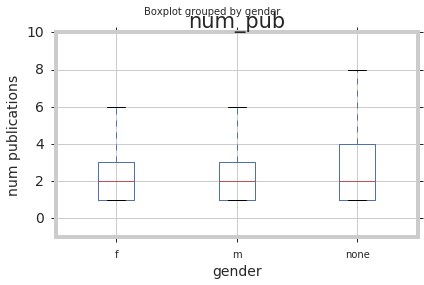

    year    author  num_pub  start_year  end_year  total_num_pub  \
10  1970  a. moore        1      1970.0    2012.0            2.0   

    career_length gender  
10           42.0      m  


In [55]:
pl = authorPublicationData.boxplot(column='num_pub', by='gender', showfliers=False)
pl.set_xlabel('gender')
pl.set_ylabel('num publications')
pl.set_ylim([-1,10])
plt.show()

print(authorPublicationData.head(n=1))

### Test Data

In [56]:
print(authorPublicationData.head(n=1))

groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))
print(np.unique(groupByYearData["year"]))

groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))
print(np.unique(groupByYearData["year"]))

    year    author  num_pub  start_year  end_year  total_num_pub  \
10  1970  a. moore        1      1970.0    2012.0            2.0   

    career_length gender  
10           42.0      m  
        year            author  num_pub  start_year  end_year  total_num_pub  \
86432   1987  donatella sciuto        1      1987.0    2016.0          349.0   
100632  1988  donatella sciuto        2      1987.0    2016.0          349.0   
117982  1989  donatella sciuto        1      1987.0    2016.0          349.0   

        career_length gender  
86432            29.0      f  
100632           29.0      f  
117982           29.0      f  
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018]
       year            author  num_pub  start_year  end_year  total_num_pub  \
45640  1987  donatella sciuto      

# Cohort Analysis on all authors for 15 years

In [57]:
years = groupByYearData['year'].unique()
years = sorted(years)
print(years)


[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


### Select Cohorts based on Start Years

In [58]:
cohort_start_years = [y for y in years if y < (END_YEAR - CAREER_LENGTH)]
#cohort_start_years = [1970, 1974, 1984, 1994, 1998]



### Cohort Analysis (Num Pub)

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


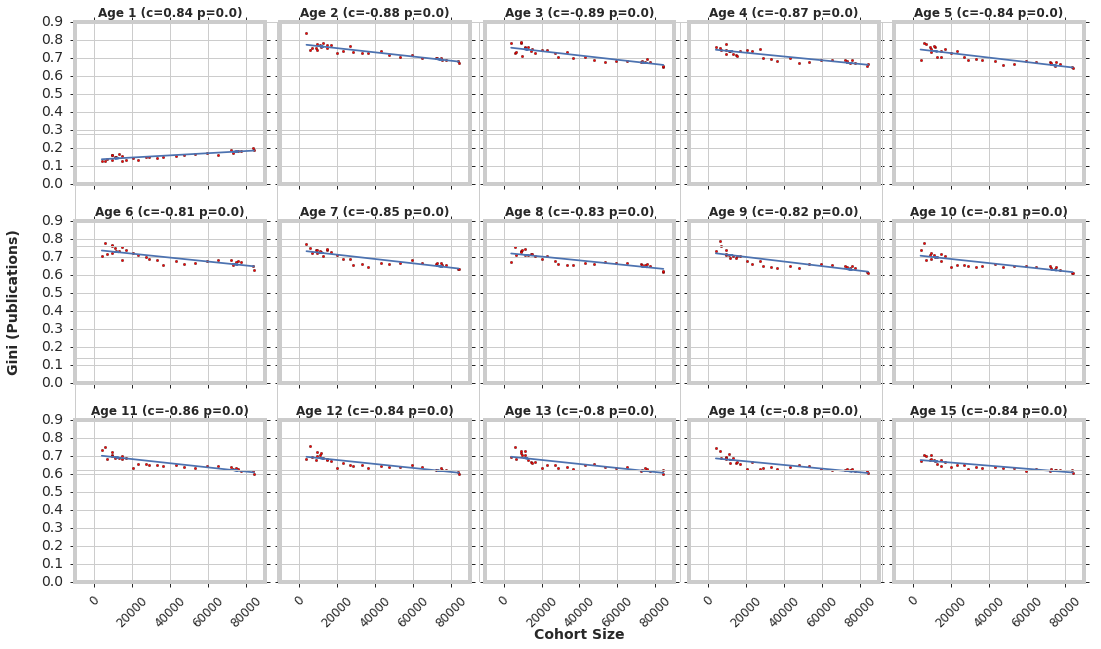

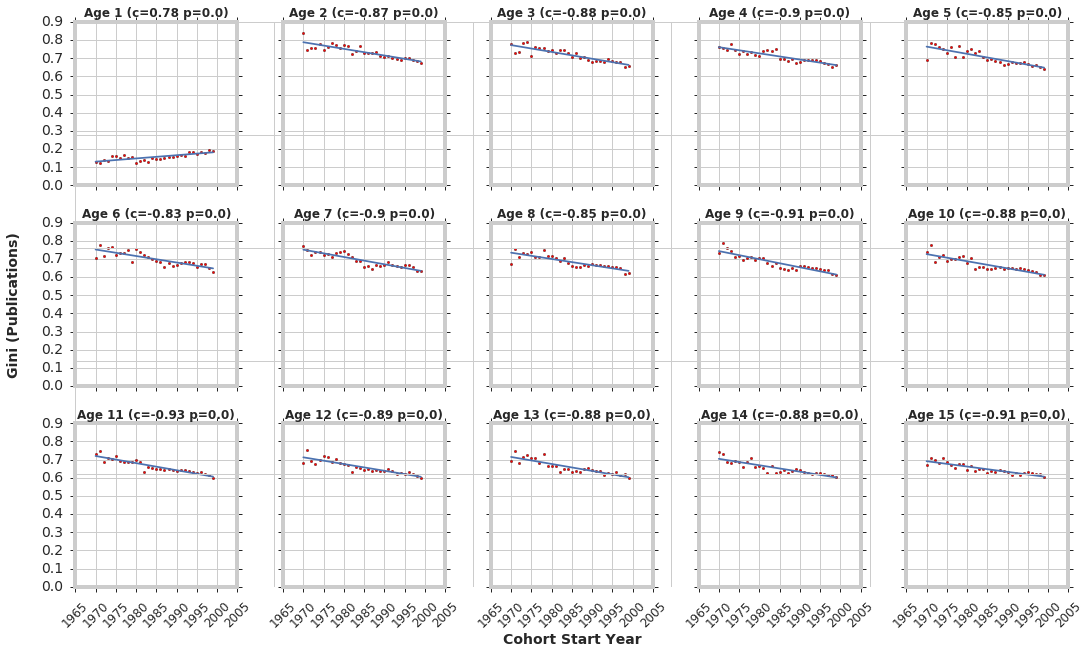

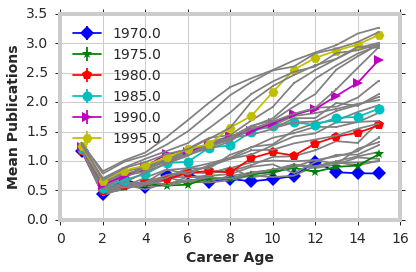

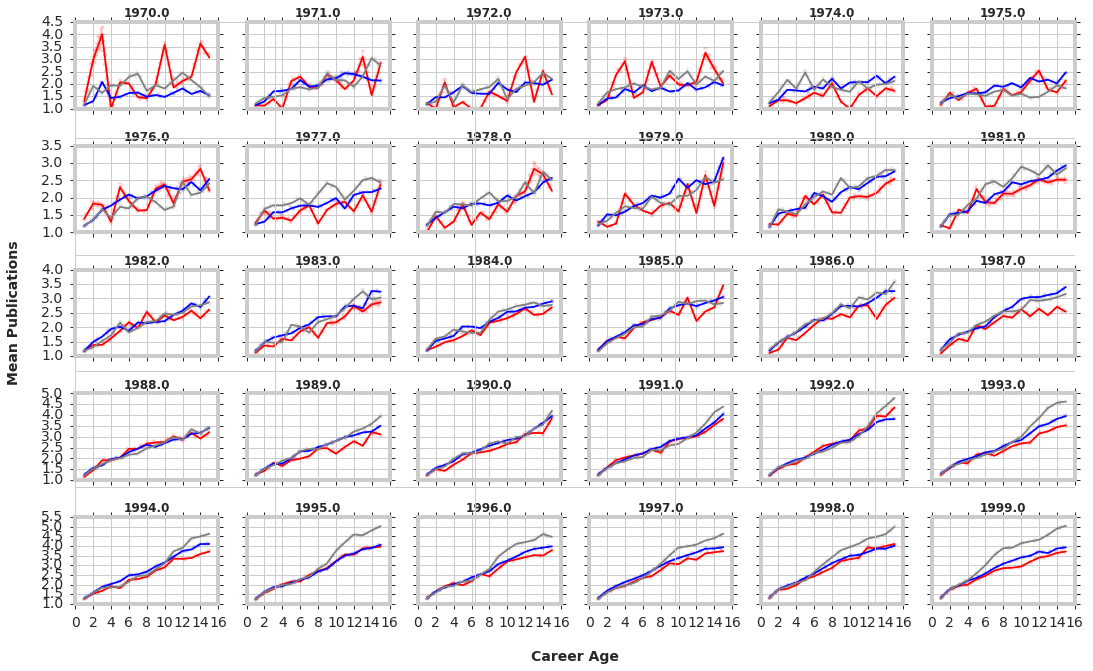

In [59]:

plot.run_cohort_analysis(groupByYearData, cohort_start_years, CAREER_LENGTH, "num_pub", "Publications")  


### Cohort Analysis (Cum Num Pub)

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


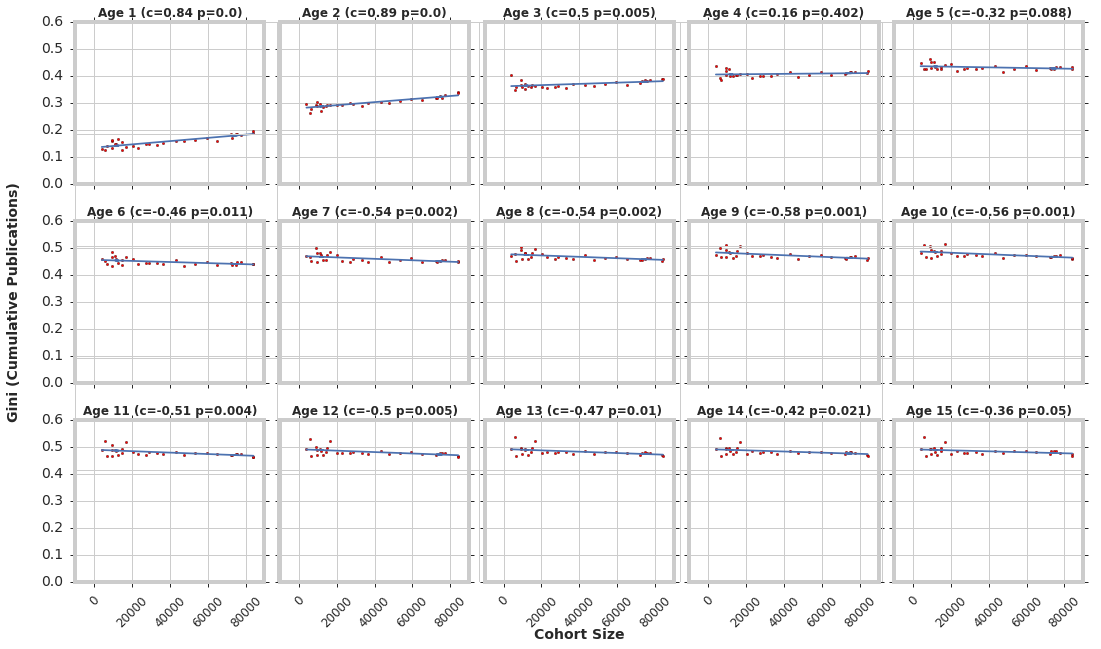

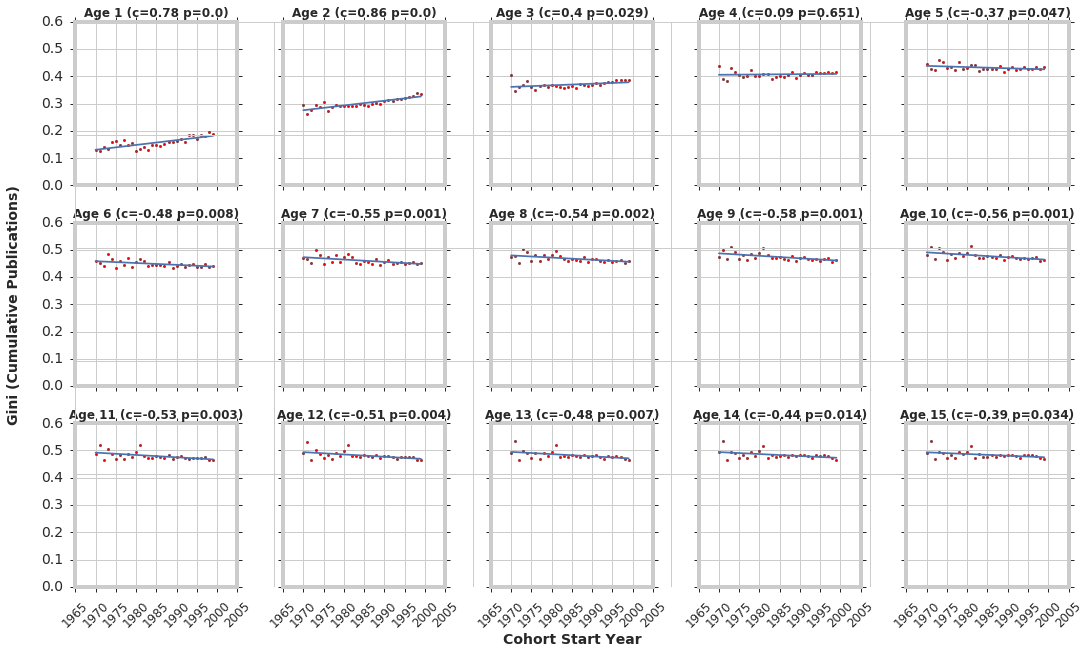

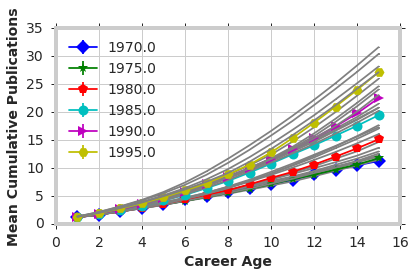

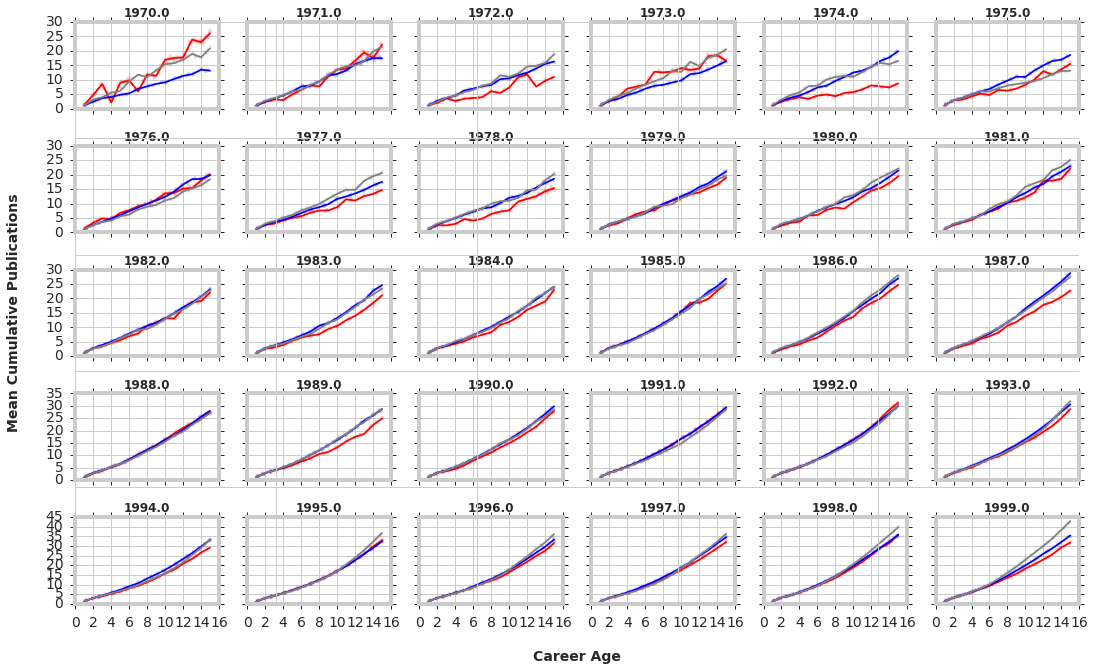

In [60]:
from importlib import reload
reload(plot)
plot.run_cohort_analysis(groupByYearData, cohort_start_years, CAREER_LENGTH, "cum_num_pub", "Cumulative Publications")  


### Cumulative Distribution of selected Cohorts for selected Career Ages

how do the distributions differ? 

  year:1970.0    age: 1
Counter({1.0: 3429, 2.0: 426, 3.0: 99, 4.0: 17})
  year:1974.0    age: 1
Counter({1.0: 7668, 2.0: 1252, 3.0: 339, 4.0: 51, 5.0: 15, 7.0: 2})
  year:1984.0    age: 1
Counter({1.0: 22625, 2.0: 3467, 3.0: 918, 4.0: 125})
  year:1994.0    age: 1
Counter({1.0: 59261, 2.0: 12565, 3.0: 2731, 4.0: 745, 5.0: 257, 6.0: 97})
  year:1998.0    age: 1
Counter({1.0: 65143, 2.0: 13755, 3.0: 3439, 4.0: 932, 5.0: 398, 6.0: 123, 8.0: 40, 10.0: 19})


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


  year:1970.0    age: 5
Counter({0.0: 2240, 1.0: 991, 2.0: 332, 3.0: 289, 4.0: 119})
  year:1974.0    age: 5
Counter({0.0: 5772, 1.0: 1980, 2.0: 950, 3.0: 207, 4.0: 207, 6.0: 150, 11.0: 39, 5.0: 22})
  year:1984.0    age: 5
Counter({0.0: 15365, 1.0: 5774, 2.0: 3226, 3.0: 1566, 4.0: 553, 5.0: 379, 6.0: 112, 8.0: 98, 9.0: 32, 7.0: 30})
  year:1994.0    age: 5
Counter({0.0: 38333, 1.0: 19259, 2.0: 8763, 3.0: 4141, 4.0: 2293, 5.0: 1308, 6.0: 769, 7.0: 363, 8.0: 203, 10.0: 110, 9.0: 42, 12.0: 24, 13.0: 24, 15.0: 24})
  year:1998.0    age: 5
Counter({0.0: 37358, 1.0: 20938, 2.0: 11021, 3.0: 6193, 4.0: 3499, 5.0: 2299, 6.0: 1016, 7.0: 490, 8.0: 251, 9.0: 226, 10.0: 190, 11.0: 133, 12.0: 79, 14.0: 59, 16.0: 39, 13.0: 38, 15.0: 20})
  year:1970.0    age: 10
Counter({0.0: 2466, 1.0: 859, 2.0: 277, 4.0: 196, 3.0: 158, 5.0: 15})
  year:1974.0    age: 10
Counter({0.0: 5495, 1.0: 2011, 2.0: 957, 3.0: 409, 4.0: 271, 5.0: 81, 6.0: 59, 8.0: 44})
  year:1984.0    age: 10
Counter({0.0: 12228, 1.0: 6023, 

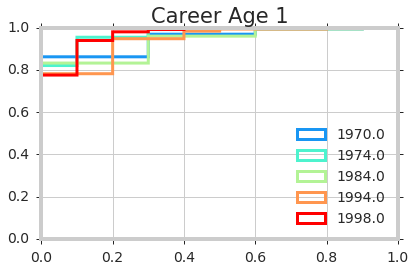

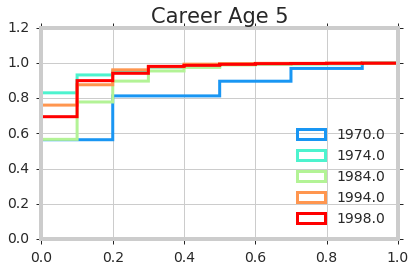

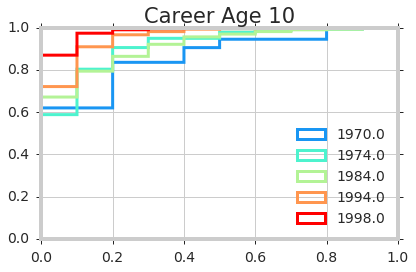

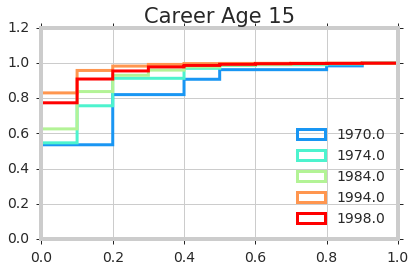

In [61]:
from importlib import reload
reload(plot)

cohort_start_years = [1970, 1974, 1984, 1994, 1998]

cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, CAREER_LENGTH, 'num_pub')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_pub', 'Number of Publications')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_pub', 'Number of Publications')
plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_pub', 'Number of Publications')
plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_pub', 'Number of Publications')



### Regression Analysis of mean productivity on Inequality for all authors for 15 years

- There is no relation at all - Reg. coefficient is 0

In [62]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)


In [63]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

Regression???
outcome variable: inequality of each cohort an each time interval (2 years)
Indepent variable: number of publications that the cohort produced during the time interval

Question: are more inequal groups, more productive?  

In [64]:
#groupByYearData = authorPublicationData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_pub')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', cohort_start_years, CAREER_LENGTH, 'Publications Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', cohort_start_years, CAREER_LENGTH, 'Cumulative Publications Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 15 years

In [65]:
#groupByYearData = authorPublicationData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_pub')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', cohort_start_years, CAREER_LENGTH, 'Publications Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', cohort_start_years, CAREER_LENGTH, 'Cumulative Publications Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)